# Clustering of atypical children based on their behavioural SDQ factors 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set()
#z-scoring
from sklearn.preprocessing import StandardScaler
#outliers
from scipy import stats
from numpy.linalg import inv
from scipy.stats import chi2
#clustering 
from sklearn.cluster import KMeans, AgglomerativeClustering 
from sklearn import metrics
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
#manifold
import umap

### load csv obtained after factor analysis in R 

In [ ]:
df_factors = pd.read_csv('factors_MCS3.csv')

In [ ]:
# merge with df_atypical_MCS3
df = pd.merge(df_atypical_MCS3, df_factors, on="MCSID")
df.describe()

## Cleaning (z-scoring, removing outliers)

In [ ]:
# only keep columns you want to z-score
dff = df['F1','F2','F3','F3','F5']

### z-scoring

In [ ]:
ss = StandardScaler()
df_z= ss.fit_transform(dff)
df_z = pd.DataFrame(df_z, columns = ['factor1', 'factor2', 'factor3','factor4','factor5'], index=df.index)#replace by column names that make sense for you
demo = df[['MCSID','age','gender']]
df_z = df_z.join(demo)
df_z = df_z.reset_index()
df_z = df_z.drop(['index'], axis=1)
df_z

### univariate outliers

In [ ]:
ax = sns.boxplot(data=df_z.iloc[:,0:5], orient="h", palette="Set2")#only plot factors (replace 0:5 by 0:number of factors)

In [ ]:
# remove univariate outliers: median absolute deviation method (MAD)
def mad_method(df, variable_name):
    #Takes two parameters: dataframe & variable of interest as string
    columns = df.columns
    med = np.median(df, axis = 0)
    mad = np.abs(stats.median_abs_deviation(df,scale='normal'))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index == item
    for i, v in enumerate(df.loc[:,variable_name]):
        t = (v-med[index])/mad[index]
        if t > threshold:
            outlier.append(i)
        else:
            continue
    return outlier


In [ ]:
#run function for each one of your columns (again if you have 3 factors replace 0:5 by 0:3)
outlier_mad1 = mad_method(df_z.iloc[:,0:5], 'factor1')
outlier_mad2 = mad_method(df_z.iloc[:,0:5], 'factor2')
outlier_mad3 = mad_method(df_z.iloc[:,0:5], 'factor3')
outlier_mad4 = mad_method(df_z.iloc[:,0:5], 'factor4')
outlier_mad5 = mad_method(df_z.iloc[:,0:5], 'factor5')

outliers_all=  np.concatenate((outlier_mad1, outlier_mad2, outlier_mad3,outlier_mad4,outlier_mad5), axis=None)
#find duplicates 
uniques = np.unique (all_out)
# print total number of univariate outliers
print(len(uniques))

In [ ]:
#remove outliers
df_zc = df_z.drop(uniques,axis=0)

In [ ]:
ax = sns.boxplot(data=df_zc, orient="h", palette="Set2")

### multivariate outliers

In [ ]:
def mahalanobis_method(df):
    #M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           #Covariance
    inv_covmat = inv(cov)                     #Inverse covariance
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    #Cut-off point
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]-1))    #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md


In [ ]:
# run function on df without univariate outliers
outliers_mahal, md = mahalanobis_method(df=df_zc)
print(len(outliers_mahal))

In [ ]:
df_zcc = df_zc.drop(df_zc.index[outliers_mahal])

In [ ]:
ax = sns.boxplot(data=df_zcc, orient="h", palette="Set2")

In [ ]:
# save df_zcc
pd.DataFrame(df_zcc).to_csv("df_zcc_atyp.csv", index = None )

## clustering without manifold embedding: try different options and see if you can obtain silhouette score>0.50 for reasonable number of clusters

### KMeans 

In [ ]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    Clusterer = kmeans.fit(df_zcc.iloc[:,0:5])#again adjust with your number of factors
    ClusterLabels = Clusterer.labels_
    silhouette_scores.append(silhouette_score(df_zcc.iloc[:,0:5], ClusterLabels ,metric='euclidean'))

In [ ]:
fig,ax = plt.subplots()
plt.plot(range(2, 10), silhouette_scores)
ax.plot(range(2, 10), silhouette_scores, color="black", marker="o")
# set x-axis label
ax.set_xlabel("number of clusters",fontsize=14)
ax.axvline(x=3, color="black", linestyle="--")#replace x=3 with the cluster number with highest silhouette score
# set y-axis label`
ax.set_ylabel("silhouette scores",color="black",fontsize=14)
ax.set_facecolor('white')
plt.savefig('silhouettesPlot_kmeans.png',dpi=300)

### Agglomerative clustering on raw df_zcc

In [ ]:
for k in range(2, 10):
    
    Agg = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    Clusterer = Agg.fit(df_zcc.iloc[:,0:5])#again adjust with your number of factors
    ClusterLabels = Clusterer.labels_
    silhouette_scores.append(silhouette_score(df_zcc.iloc[:,0:5], ClusterLabels ,metric='euclidean'))

In [ ]:
fig,ax = plt.subplots()
plt.plot(range(2, 10), silhouette_scores)
ax.plot(range(2, 10), silhouette_scores, color="black", marker="o")
# set x-axis label
ax.set_xlabel("number of clusters",fontsize=14)
ax.axvline(x=3, color="black", linestyle="--")#replace x=3 with the cluster number with highest silhouette score
# set y-axis label`
ax.set_ylabel("silhouette scores",color="black",fontsize=14)
ax.set_facecolor('white')
plt.savefig('silhouettesPlot_Agg1.png',dpi=300)

### Agglomerative clustering on precomputed similarity matrix dmat

In [ ]:
dmat = (euclidean_distances(df_zcc.iloc[:,0:5]))**2
for k in range(2, 10):
    
    Agg = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete'
    Clusterer = Agg.fit(dmat)
    ClusterLabels = Clusterer.labels_
    silhouette_scores.append(silhouette_score(dmat, ClusterLabels ,metric='euclidean'))

In [ ]:
fig,ax = plt.subplots()
plt.plot(range(2, 10), silhouette_scores)
ax.plot(range(2, 10), silhouette_scores, color="black", marker="o")
# set x-axis label
ax.set_xlabel("number of clusters",fontsize=14)
ax.axvline(x=3, color="black", linestyle="--") #replace x=3 with the cluster number with highest silhouette score
# set y-axis label`
ax.set_ylabel("silhouette scores",color="black",fontsize=14)
ax.set_facecolor('white')
plt.savefig('silhouettesPlot_Agg2.png',dpi=300)

## Manifold embedding: UMAP 

To do if you cannot find any number of clusters that fulfil the criteria silhouette score>0.50 

https://umap-learn.readthedocs.io/en/latest/basic_usage.html

In [26]:
X_UMAP = umap.UMAP(n_neighbors=50,
                      min_dist=0.01,
                      metric='correlation').fit_transform(dfSDQ_zcc.iloc[:,0:5])

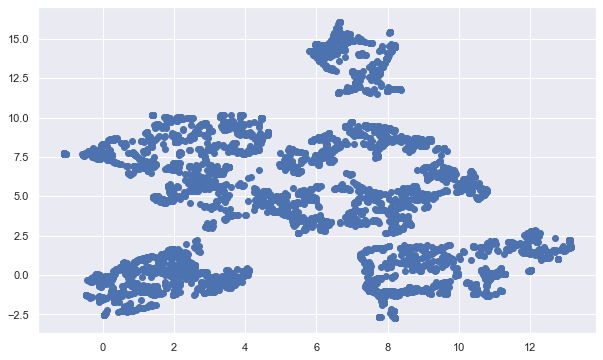

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
scatter = ax.scatter(X_UMAP[:,0],X_UMAP[:,1])

In [ ]:
# save X_UMAP to apply clusterboot in R: 
pd.DataFrame(X_UMAP).to_csv("X_UMAP_MCS3.csv", header=None, index = None )

### Kmeans on transformed data

In [ ]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    Clusterer = kmeans.fit(X_UMAP)
    ClusterLabels = Clusterer.labels_
    silhouette_scores.append(silhouette_score(X_UMAP, ClusterLabels ,metric='euclidean'))

In [ ]:
fig,ax = plt.subplots()
plt.plot(range(2, 10), silhouette_scores)
ax.plot(range(2, 10), silhouette_scores, color="black", marker="o")
# set x-axis label
ax.set_xlabel("number of clusters",fontsize=14)
ax.axvline(x=3, color="black", linestyle="--")#replace x=3 with the cluster number with highest silhouette score
# set y-axis label`
ax.set_ylabel("silhouette scores",color="black",fontsize=14)
ax.set_facecolor('white')
plt.savefig('silhouettesPlot_kmeans_UMAP.png',dpi=300)

CH index https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html can also help you to decide what the optimal number of clusters is: you are looking for higest CH index and highest increase

In [31]:
CH_scores = [] 

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    Clusterer = kmeans.fit(X_UMAP)
    ClusterLabels = Clusterer.labels_
    CH_scores.append(metrics.calinski_harabasz_score(X_UMAP, ClusterLabels))

In [ ]:
CH_increase = [100 * (b - a) / a for a, b in zip(CH_scores[::1], CH_scores[1::1])]
CH_increase = np.insert(CH_increase, 0, 'NaN', axis=0)

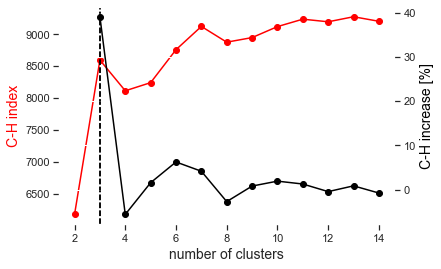

In [34]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(range(2, 15), CH_scores, color="red", marker="o")
# set x-axis label
ax.set_xlabel("number of clusters",fontsize=14)
# set y-axis label
ax.set_ylabel("C-H index",color="red",fontsize=14)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.axvline(x=3, color="black", linestyle="--")


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2,15), CH_increase,color="black",marker="o")
ax2.set_ylabel("C-H increase [%]",color="black",fontsize=14)
ax2.set_facecolor('white')
ax2.axvline(x=3, color="black", linestyle="--") #replace x=3 with the cluster number with highest CH index and CH increase
plt.show()
# save the plot as a file
fig.savefig('CH_index_UMAP.jpeg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


### Agglomerative clustering on transformed data

In [ ]:
for k in range(2, 10):
    
    Agg = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    Clusterer = Agg.fit(X_UMAP)
    ClusterLabels = Clusterer.labels_
    silhouette_scores.append(silhouette_score(X_UMAP, ClusterLabels ,metric='euclidean'))

In [ ]:
fig,ax = plt.subplots()
plt.plot(range(2, 10), silhouette_scores)
ax.plot(range(2, 10), silhouette_scores, color="black", marker="o")
# set x-axis label
ax.set_xlabel("number of clusters",fontsize=14)
ax.axvline(x=3, color="black", linestyle="--")#replace x=3 with the cluster number with highest silhouette score
# set y-axis label`
ax.set_ylabel("silhouette scores",color="black",fontsize=14)
ax.set_facecolor('white')
plt.savefig('silhouettesPlot_Agg_UMAP.png',dpi=300)

calculate CH index here (adapt code above)

### replot data in UMAP space with cluster labelling 

In [ ]:
KM = KMeans(n_clusters = 3) # change this with the optimal method and number of clusters 
Clusterer = KM.fit(X_UMAP)
labels = Clusterer.labels_
kM = pd.DataFrame(labels)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor('white')
scatter = ax.scatter(X_UMAP[0],X_UMAP[1],c=kM[0],cmap='viridis')
plt.savefig('projection_UMAP_kmeans_MCS3.png',dpi=300)

### final silhouette plot with optimal method and number of clusters

In [ ]:
    n_clusters = 3 # change accordingly here 
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dfSDQ_zcc)+ (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.

    clusterer = KMeans(n_clusters=n_clusters) # change accordingly here 
    cluster_labels = clusterer.fit_predict(X_UMAP)
    labels = clusterer.labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    #silhouette_avg = silhouette_score(Y, labels,metric='precomputed')
    silhouette_avg = silhouette_score(X_UMAP,labels,metric='euclidean')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    #sample_silhouette_values = silhouette_samples(Y, labels, metric='precomputed')
    sample_silhouette_values = silhouette_samples(X_UMAP,labels,metric='euclidean')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        color = cm.viridis(float(i) / (n_clusters-1))
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-0.1, 1])
    ax1.set_facecolor('white')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.savefig('silhouette_3clusters_UMAP_MCS3.png')

# Prepare data for transition analysis 

In [89]:
df_zcc = pd.read_csv('df_zcc_atyp.csv')

In [69]:
df_zcc

,emotion,conduct,hyperactivity,peer problems,antisocial,MCSID,EPAGE0000,EPSEX0000
0,0.826108,-0.766225,-1.794629,0.280598,-0.968139,M10016V,11,Male
1,0.385523,0.353398,0.502737,0.784938,0.606334,M10022T,10,Male
2,-1.376820,-0.766225,0.885631,-1.232421,-0.968139,M10025W,11,Male
3,-1.376820,0.913210,-0.263052,-0.728081,0.081509,M10038B,11,Female
4,0.826108,-1.326036,-0.645946,0.280598,-0.968139,M10041W,11,Female
...,...,...,...,...,...,...,...,...
5408,0.385523,0.353398,0.502737,-0.728081,0.081509,M35853G,11,Female
5409,-0.495649,0.353398,0.502737,-0.223741,-0.443315,M35864K,11,Male
5410,0.826108,1.473021,0.119842,0.280598,1.131158,M35871J,11,Male
5411,-0.055063,0.913210,-0.263052,-0.223741,0.081509,M35873L,11,Female


In [45]:
df_zcc['group']=labels

In [47]:
len(labels)

5413

In [48]:
df_typical = pd.read_csv('df_typical_MCS3.csv') #saved during preprocessing

,MCSID,EPAGE0000,EPSEX0000,emotion,conduct,hyper,peer,antisocial
0,M10007U,11,Male,3.0,1.0,3.0,0.0,2.0
1,M10015U,11,Female,2.0,1.0,3.0,0.0,0.0
3,M10018X,10,Female,1.0,2.0,1.0,1.0,2.0
4,M10020R,11,Female,2.0,1.0,0.0,1.0,1.0
5,M10021S,11,Female,1.0,1.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...
12803,M35862H,11,Female,1.0,1.0,2.0,0.0,1.0
12805,M35867N,11,Female,1.0,0.0,2.0,0.0,0.0
12806,M35868P,11,Male,0.0,0.0,2.0,0.0,1.0
12807,M35869Q,10,Female,3.0,0.0,2.0,0.0,3.0


add typical children and their factor scores

In [51]:
# merge with df_typical_MCS3 
df_typical = pd.merge(df_typical_MCS3, df_factors, on="MCSID")
df_zcc= df_zcc.append(df_typical, ignore_index=True)
df_zcc['group'] = df_zcc['group'].fillna(5)# fill with group labels not already taken 
df_zcc.head()

,emotion,conduct,hyper,peer,antisocial,MCSID,EPAGE0000,EPSEX0000,group
0,0.826108,-0.766225,-1.794629,0.280598,-0.968139,M10016V,11,Male,4.0
1,0.385523,0.353398,0.502737,0.784938,0.606334,M10022T,10,Male,2.0
2,-1.376820,-0.766225,0.885631,-1.232421,-0.968139,M10025W,11,Male,3.0
3,-1.376820,0.913210,-0.263052,-0.728081,0.081509,M10038B,11,Female,3.0
4,0.826108,-1.326036,-0.645946,0.280598,-0.968139,M10041W,11,Female,2.0
...,...,...,...,...,...,...,...,...,...
12747,1.000000,1.000000,2.000000,0.000000,1.000000,M35862H,11,Female,5.0
12748,1.000000,0.000000,2.000000,0.000000,0.000000,M35867N,11,Female,5.0
12749,0.000000,0.000000,2.000000,0.000000,1.000000,M35868P,11,Male,5.0
12750,3.000000,0.000000,2.000000,0.000000,3.000000,M35869Q,10,Female,5.0


In [52]:
# add 'original' factors to generate zscoring based on whole population 
df_all = pd.merge(df_zcc,dff, on="MCSID", how='left')
df_all

,emotion_x,conduct_x,hyper_x,peer_x,antisocial_x,MCSID,EPAGE0000_x,EPSEX0000_x,group,EPAGE0000_y,EPSEX0000_y,emotion_y,conduct_y,hyper_y,peer_y,antisocial_y,exists
0,0.826108,-0.766225,-1.794629,0.280598,-0.968139,M10016V,11,Male,4.0,11.0,Male,5.0,1.0,0.0,3.0,0.0,both
1,0.385523,0.353398,0.502737,0.784938,0.606334,M10022T,10,Male,2.0,10.0,Male,4.0,3.0,6.0,4.0,3.0,both
2,-1.376820,-0.766225,0.885631,-1.232421,-0.968139,M10025W,11,Male,3.0,11.0,Male,0.0,1.0,7.0,0.0,0.0,both
3,-1.376820,0.913210,-0.263052,-0.728081,0.081509,M10038B,11,Female,3.0,11.0,Female,0.0,4.0,4.0,1.0,2.0,both
4,0.826108,-1.326036,-0.645946,0.280598,-0.968139,M10041W,11,Female,2.0,11.0,Female,5.0,0.0,3.0,3.0,0.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12747,1.000000,1.000000,2.000000,0.000000,1.000000,M35862H,11,Female,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
12748,1.000000,0.000000,2.000000,0.000000,0.000000,M35867N,11,Female,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
12749,0.000000,0.000000,2.000000,0.000000,1.000000,M35868P,11,Male,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
12750,3.000000,0.000000,2.000000,0.000000,3.000000,M35869Q,10,Female,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


to ignore for now (we'll do it together)

In [53]:
# TO ADAPT with your own factor names
df_all['EMO']=df_all['emotion_y'].fillna(df_all['emotion_x'])
df_all['COND']=df_all['conduct_y'].fillna(df_all['conduct_x'])
df_all['HYPER']=df_all['hyper_y'].fillna(df_all['hyper_x'])
df_all['PEER']=df_all['peer_y'].fillna(df_all['peer_x'])
df_all['SOC']=df_all['antisocial_y'].fillna(df_all['antisocial_x'])
df_all['age']=df_all['EPAGE0000_x']
df_all['gender']=df_all['EPSEX0000_x']
columns_to_del = ['emotion_y','emotion_x','conduct_y','conduct_x','hyper_y','hyper_x','peer_y','peer_x','antisocial_y','antisocial_x',
                 'EPAGE0000_y','EPSEX0000_y','EPAGE0000_x','EPSEX0000_x']
df_fin = df_all.drop(columns = columns_to_del)
df_fin

,MCSID,group,EMO,COND,HYPER,PEER,SOC,age,gender
0,M10016V,4.0,5.0,1.0,0.0,3.0,0.0,11,Male
1,M10022T,2.0,4.0,3.0,6.0,4.0,3.0,10,Male
2,M10025W,3.0,0.0,1.0,7.0,0.0,0.0,11,Male
3,M10038B,3.0,0.0,4.0,4.0,1.0,2.0,11,Female
4,M10041W,2.0,5.0,0.0,3.0,3.0,0.0,11,Female
...,...,...,...,...,...,...,...,...,...
12747,M35862H,5.0,1.0,1.0,2.0,0.0,1.0,11,Female
12748,M35867N,5.0,1.0,0.0,2.0,0.0,0.0,11,Female
12749,M35868P,5.0,0.0,0.0,2.0,0.0,1.0,11,Male
12750,M35869Q,5.0,3.0,0.0,2.0,0.0,3.0,10,Female


In [54]:
# save in transitions folder 
pd.DataFrame(df_fin).to_csv("df_atyp_UMAP_5clusters_MCS3.csv")